# Qiskit Course - Lesson 4: Quantum Error Correction & Noise Mitigation

Welcome to Lesson 4 of our quantum computing journey! Building on our mastery of dynamic circuits and quantum teleportation, we now tackle one of the most critical challenges in quantum computing: **Quantum Error Correction (QEC)** and **Noise Mitigation**. This lesson bridges the gap between theoretical quantum algorithms and practical quantum computing on real, noisy hardware.

## 🚀 Installation Requirements

In [3]:
# Install required packages for error correction and noise modeling
!pip install qiskit[all]~=2.1.1
!pip install qiskit-aer~=0.17
!pip install qiskit-ibm-runtime~=0.41.1
!pip install qiskit-experiments~=0.6.0
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scipy
!pip install networkx
!pip install pylatexenc

   ---------------------------------------- 0.0/733.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/733.6 kB ? eta -:--:--
   ---------------------------- ----------- 524.3/733.6 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 733.6/733.6 kB 1.4 MB/s eta 0:00:00

   ---------------- ----------------------- 2/5 [lmfit]
   -------------------------------- ------- 4/5 [qiskit-experiments]
   -------------------------------- ------- 4/5 [qiskit-experiments]
   -------------------------------- ------- 4/5 [qiskit-experiments]
   -------------------------------- ------- 4/5 [qiskit-experiments]
   ---------------------------------------- 5/5 [qiskit-experiments]



In [19]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler

# 🔧 FIX: Correct noise model imports
from qiskit_aer.noise import (NoiseModel, depolarizing_error, amplitude_damping_error, 
                             phase_damping_error, ReadoutError, thermal_relaxation_error)
# Note: ReadoutError (capital R) instead of readout_error

from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import (SparsePauliOp, Statevector, DensityMatrix, random_statevector,
                                Pauli, process_fidelity, state_fidelity, partial_trace)
from qiskit.visualization import plot_histogram, circuit_drawer, plot_bloch_multivector
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style for beautiful visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

print("✅ All imports successful!")


✅ All imports successful!


## 📚 Understanding Quantum Errors and Noise

Quantum computers are extremely sensitive to environmental noise, making quantum error correction essential for practical quantum computation. Unlike classical computers where errors are rare bit flips, quantum systems face continuous, complex errors affecting both amplitude and phase.

### **🎯 Types of Quantum Errors:**

#### **1. Coherent Errors (Systematic)**
- **Over/Under-rotations**: Gate parameters slightly wrong
- **Crosstalk**: Unintended interactions between qubits  
- **Calibration drift**: Parameter changes over time
- **Control errors**: Imperfect pulse sequences

#### **2. Incoherent Errors (Random)**
- **T₁ decay (Amplitude damping)**: Energy loss to environment
- **T₂ dephasing (Phase damping)**: Loss of quantum coherence
- **Thermal noise**: Random thermal fluctuations
- **Measurement errors**: Imperfect state discrimination

#### **3. Correlated Errors**
- **Crosstalk-induced correlations**: Neighboring qubit interactions
- **Common-mode noise**: Environmental fluctuations affecting multiple qubits
- **Control line coupling**: Shared control electronics

### **🔬 The Mathematics of Quantum Noise:**

Quantum noise is described by **quantum channels** - completely positive trace-preserving (CPTP) maps that transform density matrices:

\\[ \mathcal{E}(\rho) = \sum_i K_i \rho K_i^\dagger \\]

where \(K_i\) are **Kraus operators** satisfying \(\sum_i K_i^\dagger K_i = I\\).

In [20]:
def explain_quantum_noise_models():
    """
    Explains different quantum noise models and their physical origins.
    """
    print("🌪️ QUANTUM NOISE MODELS")
    print("=" * 60)
    
    print("\n🎯 1. DEPOLARIZING NOISE")
    print("   • Physical origin: Random Pauli errors")
    print("   • Mathematical model: ρ → (1-p)ρ + p·I/2")
    print("   • Kraus operators: √(1-3p/4)·I, √(p/4)·X, √(p/4)·Y, √(p/4)·Z")
    print("   • Effect: Mixes state with maximally mixed state")
    print("   • Common in: Gate operations, environmental decoherence")
    
    print("\n⬇️ 2. AMPLITUDE DAMPING (T₁ DECAY)")
    print("   • Physical origin: Energy loss to environment")
    print("   • Mathematical model: |1⟩ → |0⟩ transition")
    print("   • Kraus operators: K₀ = [[1,0],[0,√(1-γ)]], K₁ = [[0,√γ],[0,0]]")
    print("   • Effect: Population decay from excited to ground state")
    print("   • Time scale: T₁ relaxation time")
    
    print("\n🌀 3. PHASE DAMPING (T₂ DEPHASING)")
    print("   • Physical origin: Random phase fluctuations")
    print("   • Mathematical model: Coherences decay exponentially")
    print("   • Kraus operators: K₀ = [[1,0],[0,√(1-λ)]], K₁ = [[0,0],[0,√λ]]")
    print("   • Effect: Loss of quantum superposition")
    print("   • Time scale: T₂* dephasing time")
    
    print("\n🌡️ 4. THERMAL RELAXATION")
    print("   • Physical origin: Finite temperature environment")
    print("   • Mathematical model: Equilibration to thermal state")
    print("   • Parameters: T₁, T₂, gate time, temperature")
    print("   • Effect: Combination of amplitude and phase damping")
    print("   • Realistic: Models actual superconducting qubit behavior")
    
    print("\n📊 5. READOUT ERRORS")
    print("   • Physical origin: Imperfect state discrimination")
    print("   • Mathematical model: Classical confusion matrix")
    print("   • Parameters: P(0|1) and P(1|0) error probabilities")
    print("   • Effect: Measurement outcome flips")
    print("   • Mitigation: Readout error correction matrices")

explain_quantum_noise_models()

🌪️ QUANTUM NOISE MODELS

🎯 1. DEPOLARIZING NOISE
   • Physical origin: Random Pauli errors
   • Mathematical model: ρ → (1-p)ρ + p·I/2
   • Kraus operators: √(1-3p/4)·I, √(p/4)·X, √(p/4)·Y, √(p/4)·Z
   • Effect: Mixes state with maximally mixed state
   • Common in: Gate operations, environmental decoherence

⬇️ 2. AMPLITUDE DAMPING (T₁ DECAY)
   • Physical origin: Energy loss to environment
   • Mathematical model: |1⟩ → |0⟩ transition
   • Kraus operators: K₀ = [[1,0],[0,√(1-γ)]], K₁ = [[0,√γ],[0,0]]
   • Effect: Population decay from excited to ground state
   • Time scale: T₁ relaxation time

🌀 3. PHASE DAMPING (T₂ DEPHASING)
   • Physical origin: Random phase fluctuations
   • Mathematical model: Coherences decay exponentially
   • Kraus operators: K₀ = [[1,0],[0,√(1-λ)]], K₁ = [[0,0],[0,√λ]]
   • Effect: Loss of quantum superposition
   • Time scale: T₂* dephasing time

🌡️ 4. THERMAL RELAXATION
   • Physical origin: Finite temperature environment
   • Mathematical model: Equilibr

## 🛠️ Creating Realistic Noise Models
Let's create comprehensive noise models that simulate real quantum hardware conditions.

In [27]:
def create_realistic_noise_model():
    """
    Creates a realistic noise model based on current quantum hardware parameters.
    """
    print("🛠️ CREATING REALISTIC NOISE MODEL")
    print("=" * 50)
    
    # Initialize noise model
    noise_model = NoiseModel()
    
    # 1. Single-qubit gate errors
    print("\n⚙️ Single-Qubit Gate Errors:")
    
    # Depolarizing error for single-qubit gates
    single_qubit_error_rate = 0.001  # 0.1% error rate
    single_qubit_error = depolarizing_error(single_qubit_error_rate, 1)
    
    # Add to common single-qubit gates
    single_qubit_gates = ['u1', 'u2', 'u3', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz']
    for gate in single_qubit_gates:
        noise_model.add_all_qubit_quantum_error(single_qubit_error, gate)
    
    print(f"   • Depolarizing error rate: {single_qubit_error_rate}")
    print(f"   • Applied to gates: {single_qubit_gates}")
    
    # 2. Two-qubit gate errors
    print("\n🔗 Two-Qubit Gate Errors:")
    
    # Higher error rate for two-qubit gates
    two_qubit_error_rate = 0.01  # 1% error rate
    two_qubit_error = depolarizing_error(two_qubit_error_rate, 2)
    
    # Add to CNOT gates
    noise_model.add_all_qubit_quantum_error(two_qubit_error, 'cx')
    
    print(f"   • Depolarizing error rate: {two_qubit_error_rate}")
    print(f"   • Applied to: CNOT gates")
    
    # 3. Thermal relaxation errors
    print("\n🌡️ Thermal Relaxation:")
    
    # Realistic T1 and T2 times (in seconds - corrected units)
    T1 = 50e-6  # 50 μs T1 time
    T2 = 70e-6  # 70 μs T2 time  
    gate_time = 0.1e-6  # 100 ns gate time
    temperature = 0.015  # 15 mK
    
    # 🔧 FIX: Import the thermal relaxation error function
    from qiskit_aer.noise.errors import thermal_relaxation_error
    
    # Create thermal relaxation error
    thermal_error = thermal_relaxation_error(T1, T2, gate_time, temperature)
    
    # Add to all single-qubit gates
    for gate in single_qubit_gates:
        noise_model.add_all_qubit_quantum_error(thermal_error, gate, warnings=False)
    
    print(f"   • T₁ time: {T1*1e6:.1f} μs")
    print(f"   • T₂ time: {T2*1e6:.1f} μs")
    print(f"   • Gate time: {gate_time*1e9:.1f} ns")
    print(f"   • Temperature: {temperature*1000:.1f} mK")
    
    # 4. Readout errors
    print("\n📊 Readout Errors:")
    
    # Asymmetric readout errors
    prob_meas0_prep1 = 0.02  # 2% chance of measuring 0 when prepared in 1
    prob_meas1_prep0 = 0.01  # 1% chance of measuring 1 when prepared in 0
    
    readout_error_matrix = [[1 - prob_meas1_prep0, prob_meas1_prep0],
                           [prob_meas0_prep1, 1 - prob_meas0_prep1]]
    
    # 🔧 FIX: Create ReadoutError correctly
    readout_error = ReadoutError(readout_error_matrix)
    noise_model.add_all_qubit_readout_error(readout_error)
    
    print(f"   • P(0|1): {prob_meas0_prep1}")
    print(f"   • P(1|0): {prob_meas1_prep0}")
    
    print(f"\n✅ Noise model created with {len(noise_model.noise_instructions)} instruction types")
    
    return noise_model

# Create realistic noise model
realistic_noise = create_realistic_noise_model()


🛠️ CREATING REALISTIC NOISE MODEL

⚙️ Single-Qubit Gate Errors:
   • Depolarizing error rate: 0.001
   • Applied to gates: ['u1', 'u2', 'u3', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz']

🔗 Two-Qubit Gate Errors:
   • Depolarizing error rate: 0.01
   • Applied to: CNOT gates

🌡️ Thermal Relaxation:
   • T₁ time: 50.0 μs
   • T₂ time: 70.0 μs
   • Gate time: 100.0 ns
   • Temperature: 15.0 mK

📊 Readout Errors:
   • P(0|1): 0.02
   • P(1|0): 0.01

✅ Noise model created with 14 instruction types


## 📊 Demonstrating the Impact of Noise

Let's see how noise affects quantum circuits and why error correction is essential.

In [28]:
def demonstrate_noise_impact():
    """
    Demonstrates how noise affects quantum circuits of increasing complexity.
    """
    print("📊 NOISE IMPACT DEMONSTRATION")
    print("=" * 50)
    
    # Create test circuits of varying depth
    circuits = {}
    
    # 1. Simple single-qubit circuit
    qc_simple = QuantumCircuit(1, 1)
    qc_simple.h(0)
    qc_simple.measure(0, 0)
    circuits['Simple H'] = qc_simple
    
    # 2. Bell state preparation
    qc_bell = QuantumCircuit(2, 2)
    qc_bell.h(0)
    qc_bell.cx(0, 1)
    qc_bell.measure_all()
    circuits['Bell State'] = qc_bell
    
    # 3. GHZ state (3 qubits)
    qc_ghz = QuantumCircuit(3, 3)
    qc_ghz.h(0)
    qc_ghz.cx(0, 1)
    qc_ghz.cx(1, 2)
    qc_ghz.measure_all()
    circuits['GHZ State'] = qc_ghz
    
    # 4. Deep circuit (many gates)
    qc_deep = QuantumCircuit(2, 2)
    for _ in range(10):  # 10 layers of gates
        qc_deep.h(0)
        qc_deep.cx(0, 1)
        qc_deep.rz(np.pi/4, 0)
        qc_deep.rz(np.pi/4, 1)
    qc_deep.measure_all()
    circuits['Deep Circuit'] = qc_deep
    
    # Create simulators
    ideal_simulator = AerSimulator()
    noisy_simulator = AerSimulator(noise_model=realistic_noise)
    
    results = {}
    
    for name, circuit in circuits.items():
        print(f"\n🎯 Testing: {name}")
        print(f"   Circuit depth: {circuit.depth()}")
        print(f"   Number of gates: {sum(circuit.count_ops().values())}")
        
        # Run ideal simulation
        ideal_job = ideal_simulator.run(circuit, shots=1000)
        ideal_counts = ideal_job.result().get_counts()
        
        # Run noisy simulation  
        noisy_job = noisy_simulator.run(circuit, shots=1000)
        noisy_counts = noisy_job.result().get_counts()
        
        # Calculate fidelity
        fidelity = calculate_distribution_fidelity(ideal_counts, noisy_counts)
        
        print(f"   Ideal results: {ideal_counts}")
        print(f"   Noisy results: {noisy_counts}")
        print(f"   Fidelity: {fidelity:.4f}")
        
        results[name] = {
            'ideal': ideal_counts,
            'noisy': noisy_counts,
            'fidelity': fidelity,
            'depth': circuit.depth(),
            'gates': sum(circuit.count_ops().values())
        }
    
    return results

def calculate_distribution_fidelity(counts1, counts2):
    """Calculate fidelity between two measurement distributions."""
    # Normalize to probabilities
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())
    
    prob1 = {k: v/total1 for k, v in counts1.items()}
    prob2 = {k: v/total2 for k, v in counts2.items()}
    
    # Calculate overlap fidelity
    all_outcomes = set(prob1.keys()) | set(prob2.keys())
    fidelity = sum(np.sqrt(prob1.get(outcome, 0) * prob2.get(outcome, 0)) 
                  for outcome in all_outcomes)
    
    return fidelity

# Demonstrate noise impact
noise_impact_results = demonstrate_noise_impact()

📊 NOISE IMPACT DEMONSTRATION

🎯 Testing: Simple H
   Circuit depth: 2
   Number of gates: 2
   Ideal results: {'0': 461, '1': 539}
   Noisy results: {'0': 499, '1': 501}
   Fidelity: 0.9993

🎯 Testing: Bell State
   Circuit depth: 3
   Number of gates: 5
   Ideal results: {'11 00': 482, '00 00': 518}
   Noisy results: {'10 00': 22, '00 00': 489, '11 00': 466, '01 00': 23}
   Fidelity: 0.9772

🎯 Testing: GHZ State
   Circuit depth: 4
   Number of gates: 7
   Ideal results: {'000 000': 489, '111 000': 511}
   Noisy results: {'110 000': 14, '111 000': 471, '011 000': 10, '010 000': 11, '100 000': 5, '101 000': 10, '001 000': 10, '000 000': 469}
   Fidelity: 0.9695

🎯 Testing: Deep Circuit
   Circuit depth: 31
   Number of gates: 43
   Ideal results: {'10 00': 254, '00 00': 642, '11 00': 76, '01 00': 28}
   Noisy results: {'11 00': 104, '10 00': 234, '00 00': 580, '01 00': 82}
   Fidelity: 0.9908


## 🛡️ Quantum Error Correction Fundamentals

Quantum error correction protects quantum information by encoding logical qubits into multiple physical qubits and using syndrome detection to identify and correct errors.

### **🔑 Key Principles:**

1. **Redundancy**: Encode 1 logical qubit into n physical qubits
2. **Syndrome Detection**: Measure error syndromes without disturbing data
3. **Error Correction**: Apply corrections based on syndrome results
4. **Fault Tolerance**: Errors in correction don't spread to data

In [29]:
def explain_qec_principles():
    """
    Explains the fundamental principles of quantum error correction.
    """
    print("🛡️ QUANTUM ERROR CORRECTION PRINCIPLES")
    print("=" * 60)
    
    print("\n🎯 THE CHALLENGE:")
    print("   • No-cloning theorem: Cannot copy quantum states")
    print("   • Measurement destroys superposition")
    print("   • Continuous errors vs discrete classical errors")
    print("   • Need to correct without looking at data")
    
    print("\n💡 THE SOLUTION - STABILIZER CODES:")
    print("   • Encode logical qubit in subspace of n physical qubits")
    print("   • Define stabilizer operators that commute with logical operators")
    print("   • Measure stabilizers (syndromes) to detect errors")
    print("   • Apply corrections based on syndrome patterns")
    
    print("\n🔬 STABILIZER FORMALISM:")
    print("   • Stabilizer group S = ⟨g₁, g₂, ..., gᵣ⟩")
    print("   • Code space: states |ψ⟩ such that gᵢ|ψ⟩ = |ψ⟩ for all i")
    print("   • Error syndrome: s = (⟨g₁⟩, ⟨g₂⟩, ..., ⟨gᵣ⟩)")
    print("   • Syndrome identifies error without measuring data")
    
    print("\n📏 QUANTUM ERROR CORRECTION CONDITIONS:")
    print("   • For correctable error set ℰ:")
    print("   • ⟨ψ|Eᵢ†Eⱼ|ψ'⟩ = Cᵢⱼδₚₚ' for all |ψ⟩,|ψ'⟩ ∈ code space")
    print("   • Different errors must be distinguishable")
    print("   • Correctable errors can't take codewords out of code space")
    
    print("\n🎯 DISTANCE AND THRESHOLD:")
    print("   • Distance d: minimum weight of nontrivial logical operator")
    print("   • Can correct t errors if d ≥ 2t + 1")
    print("   • Threshold theorem: arbitrarily long computation possible")
    print("   • if physical error rate < threshold (∼10⁻⁴)")

explain_qec_principles()

🛡️ QUANTUM ERROR CORRECTION PRINCIPLES

🎯 THE CHALLENGE:
   • No-cloning theorem: Cannot copy quantum states
   • Measurement destroys superposition
   • Continuous errors vs discrete classical errors
   • Need to correct without looking at data

💡 THE SOLUTION - STABILIZER CODES:
   • Encode logical qubit in subspace of n physical qubits
   • Define stabilizer operators that commute with logical operators
   • Measure stabilizers (syndromes) to detect errors
   • Apply corrections based on syndrome patterns

🔬 STABILIZER FORMALISM:
   • Stabilizer group S = ⟨g₁, g₂, ..., gᵣ⟩
   • Code space: states |ψ⟩ such that gᵢ|ψ⟩ = |ψ⟩ for all i
   • Error syndrome: s = (⟨g₁⟩, ⟨g₂⟩, ..., ⟨gᵣ⟩)
   • Syndrome identifies error without measuring data

📏 QUANTUM ERROR CORRECTION CONDITIONS:
   • For correctable error set ℰ:
   • ⟨ψ|Eᵢ†Eⱼ|ψ'⟩ = Cᵢⱼδₚₚ' for all |ψ⟩,|ψ'⟩ ∈ code space
   • Different errors must be distinguishable
   • Correctable errors can't take codewords out of code space

🎯 DISTANCE A

## 🔧 Implementing the 3-Qubit Bit-Flip Code

Let's implement the simplest quantum error correction code - the 3-qubit bit-flip code.

In [33]:
def create_three_qubit_bit_flip_code():
    """
    Creates a 3-qubit bit-flip code that corrects single X errors.
    """
    print("🔧 3-QUBIT BIT-FLIP CODE IMPLEMENTATION")
    print("=" * 50)
    
    print("\n📚 Code Description:")
    print("   • Logical |0⟩ = |000⟩")
    print("   • Logical |1⟩ = |111⟩")
    print("   • Protects against single bit-flip (X) errors")
    print("   • Stabilizers: Z₀Z₁, Z₁Z₂")
    print("   • Distance: 3 (can correct 1 error)")
    
    class ThreeQubitBitFlipCode:
        def __init__(self):
            self.n_data = 3      # Number of data qubits
            self.n_ancilla = 2   # Number of syndrome qubits
            self.n_total = self.n_data + self.n_ancilla
            
        def encode_circuit(self):
            """Create encoding circuit for arbitrary state."""
            qc = QuantumCircuit(self.n_total, self.n_ancilla)
            
            # Encode logical qubit 0 into physical qubits 0,1,2
            # |ψ⟩ = α|0⟩ + β|1⟩ → α|000⟩ + β|111⟩
            qc.cx(0, 1)  # Copy bit 0 to bit 1
            qc.cx(0, 2)  # Copy bit 0 to bit 2
            
            qc.barrier(label="Encoding")
            return qc
        
        def syndrome_circuit(self):
            """Create syndrome measurement circuit."""
            qc = QuantumCircuit(self.n_total, self.n_ancilla)
            
            # Measure stabilizer Z₀Z₁ using ancilla qubit 3
            qc.cx(0, 3)  # Control: data qubit 0
            qc.cx(1, 3)  # Control: data qubit 1
            qc.measure(3, 0)  # Measure syndrome bit 0
            
            # Measure stabilizer Z₁Z₂ using ancilla qubit 4  
            qc.cx(1, 4)  # Control: data qubit 1
            qc.cx(2, 4)  # Control: data qubit 2
            qc.measure(4, 1)  # Measure syndrome bit 1
            
            qc.barrier(label="Syndrome")
            return qc
        
        def full_qec_circuit(self, error_qubit=None):
            """Create complete QEC circuit with optional error injection."""
            # 🔧 FIX: Create single circuit instead of composing multiple circuits
            qc = QuantumCircuit(self.n_total, self.n_ancilla + self.n_data)
            
            # Step 1: Encoding
            qc.cx(0, 1)  # Copy bit 0 to bit 1
            qc.cx(0, 2)  # Copy bit 0 to bit 2
            qc.barrier(label="Encoding")
            
            # Step 2: Error injection (for testing)
            if error_qubit is not None:
                qc.x(error_qubit)
                qc.barrier(label=f"Error on qubit {error_qubit}")
            
            # Step 3: Syndrome measurement
            qc.cx(0, 3)  # Control: data qubit 0
            qc.cx(1, 3)  # Control: data qubit 1
            qc.measure(3, 0)  # Measure syndrome bit 0
            
            qc.cx(1, 4)  # Control: data qubit 1
            qc.cx(2, 4)  # Control: data qubit 2
            qc.measure(4, 1)  # Measure syndrome bit 1
            qc.barrier(label="Syndrome")
            
            # Step 4: Error correction with proper conditional logic
            # 🔧 FIX: Use simpler conditional structure
            
            # Apply X₂ if syndrome = 01 (syndrome bits: bit 0 = 0, bit 1 = 1)
            with qc.if_test((qc.clbits[1], 1)):  # Check if syndrome bit 1 = 1
                with qc.if_test((qc.clbits[0], 0)):  # Check if syndrome bit 0 = 0
                    qc.x(2)
            
            # Apply X₀ if syndrome = 10 (syndrome bits: bit 0 = 1, bit 1 = 0)
            with qc.if_test((qc.clbits[0], 1)):  # Check if syndrome bit 0 = 1
                with qc.if_test((qc.clbits[1], 0)):  # Check if syndrome bit 1 = 0
                    qc.x(0)
            
            # Apply X₁ if syndrome = 11 (syndrome bits: bit 0 = 1, bit 1 = 1)
            with qc.if_test((qc.clbits[0], 1)):  # Check if syndrome bit 0 = 1
                with qc.if_test((qc.clbits[1], 1)):  # Check if syndrome bit 1 = 1
                    qc.x(1)
            
            qc.barrier(label="Correction")
            
            # Step 5: Final measurement of data qubits
            qc.measure(range(self.n_data), range(self.n_ancilla, self.n_ancilla + self.n_data))
            
            return qc
    
    return ThreeQubitBitFlipCode()

# Create the 3-qubit bit-flip code
bit_flip_code = create_three_qubit_bit_flip_code()

# Test with different error scenarios
print("\n🧪 Testing Error Correction:")

test_scenarios = [
    (None, "No error"),
    (0, "Error on qubit 0"),
    (1, "Error on qubit 1"), 
    (2, "Error on qubit 2")
]

for error_qubit, description in test_scenarios:
    print(f"\n📊 {description}:")
    
    # Create test circuit
    test_circuit = bit_flip_code.full_qec_circuit(error_qubit)
    
    print(f"   Circuit depth: {test_circuit.depth()}")
    print(f"   Number of operations: {sum(test_circuit.count_ops().values())}")
    
    # Run simulation
    simulator = AerSimulator()
    job = simulator.run(test_circuit, shots=1000)
    result = job.result().get_counts()
    
    # Analyze results
    for bitstring, count in result.items():
        if len(bitstring) >= 5:  # syndrome + data bits
            syndrome_bits = bitstring[-2:]  # Last 2 bits are syndromes
            data_bits = bitstring[:-2]      # First 3 bits are final data state
            print(f"   Syndrome: {syndrome_bits}, Final state: {data_bits}, Count: {count}")



🔧 3-QUBIT BIT-FLIP CODE IMPLEMENTATION

📚 Code Description:
   • Logical |0⟩ = |000⟩
   • Logical |1⟩ = |111⟩
   • Protects against single bit-flip (X) errors
   • Stabilizers: Z₀Z₁, Z₁Z₂
   • Distance: 3 (can correct 1 error)

🧪 Testing Error Correction:

📊 No error:
   Circuit depth: 11
   Number of operations: 17
   Syndrome: 00, Final state: 000, Count: 1000

📊 Error on qubit 0:
   Circuit depth: 12
   Number of operations: 19
   Syndrome: 01, Final state: 000, Count: 1000

📊 Error on qubit 1:
   Circuit depth: 12
   Number of operations: 19
   Syndrome: 11, Final state: 000, Count: 1000

📊 Error on qubit 2:
   Circuit depth: 12
   Number of operations: 19
   Syndrome: 10, Final state: 000, Count: 1000


## 🔬 Advanced: Steane 7-Qubit Code

Let's implement a more sophisticated error correction code that can correct both bit-flip and phase-flip errors.

In [34]:
def create_steane_seven_qubit_code():
    """
    Implements the Steane 7-qubit code - first quantum error correcting code
    that can correct arbitrary single-qubit errors.
    """
    print("🔬 STEANE 7-QUBIT CODE IMPLEMENTATION")
    print("=" * 50)
    
    print("\n📚 Code Description:")
    print("   • Encodes 1 logical qubit into 7 physical qubits")
    print("   • CSS code: Calderbank-Shor-Steane construction")
    print("   • Corrects arbitrary single-qubit errors (X, Y, Z)")
    print("   • Distance: 3")
    print("   • Based on classical [7,4,3] Hamming code")
    
    class SteaneCode:
        def __init__(self):
            self.n_data = 7
            self.n_ancilla = 6  # 3 for X syndromes, 3 for Z syndromes
            self.n_total = self.n_data + self.n_ancilla
            
            # Stabilizer generators (in binary representation)
            self.x_stabilizers = [
                [1, 0, 1, 0, 1, 0, 1],  # X₀X₂X₄X₆
                [0, 1, 1, 0, 0, 1, 1],  # X₁X₂X₅X₆
                [0, 0, 0, 1, 1, 1, 1]   # X₃X₄X₅X₆
            ]
            
            self.z_stabilizers = [
                [1, 0, 1, 0, 1, 0, 1],  # Z₀Z₂Z₄Z₆
                [0, 1, 1, 0, 0, 1, 1],  # Z₁Z₂Z₅Z₆
                [0, 0, 0, 1, 1, 1, 1]   # Z₃Z₄Z₅Z₆
            ]
        
        def encode_circuit(self):
            """Create encoding circuit for Steane code."""
            qc = QuantumCircuit(self.n_total)
            
            # Encoding based on generator matrix
            # This is a simplified encoding - full implementation would
            # use the systematic form of the generator matrix
            
            # Step 1: Create even parity groups
            qc.cx(0, 1)  # Qubit 1 = parity of group 1
            qc.cx(0, 2)  # Qubit 2 = parity of group 2  
            qc.cx(0, 3)  # Qubit 3 = parity of group 3
            
            # Step 2: Additional encoding operations
            qc.cx(1, 4)
            qc.cx(2, 5)
            qc.cx(3, 6)
            
            # Step 3: Final parity operations
            qc.cx(4, 1)
            qc.cx(5, 2)
            qc.cx(6, 3)
            
            qc.barrier(label="Steane Encoding")
            return qc
        
        def x_syndrome_circuit(self):
            """Measure X-error syndromes."""
            qc = QuantumCircuit(self.n_total, 3)
            
            # Measure each X stabilizer
            for i, stabilizer in enumerate(self.x_stabilizers):
                ancilla_qubit = self.n_data + i
                
                # Apply CNOT gates for each qubit in stabilizer
                for j, bit in enumerate(stabilizer):
                    if bit == 1:
                        qc.cx(j, ancilla_qubit)
                
                # Measure ancilla
                qc.measure(ancilla_qubit, i)
            
            qc.barrier(label="X Syndromes")
            return qc
        
        def z_syndrome_circuit(self):
            """Measure Z-error syndromes."""
            qc = QuantumCircuit(self.n_total, 3)
            
            # Measure each Z stabilizer
            for i, stabilizer in enumerate(self.z_stabilizers):
                ancilla_qubit = self.n_data + 3 + i
                
                # Apply CZ gates (implemented as H-CNOT-H)
                for j, bit in enumerate(stabilizer):
                    if bit == 1:
                        qc.h(ancilla_qubit)
                        qc.cx(j, ancilla_qubit)
                        qc.h(ancilla_qubit)
                
                # Measure ancilla
                qc.measure(ancilla_qubit, i)
            
            qc.barrier(label="Z Syndromes")
            return qc
        
        def lookup_correction(self, x_syndrome, z_syndrome):
            """
            Lookup table for error correction based on syndrome patterns.
            Returns (error_type, error_qubit) tuple.
            """
            syndrome = (tuple(x_syndrome), tuple(z_syndrome))
            
            # Simplified lookup table (partial implementation)
            lookup = {
                ((0,0,0), (0,0,0)): (None, None),    # No error
                ((1,0,0), (1,0,0)): ('Y', 0),        # Y error on qubit 0
                ((1,0,0), (0,0,0)): ('X', 0),        # X error on qubit 0
                ((0,0,0), (1,0,0)): ('Z', 0),        # Z error on qubit 0
                # ... (full lookup table would have 64 entries)
            }
            
            return lookup.get(syndrome, ('Unknown', None))
        
        def demonstrate_steane_properties(self):
            """Demonstrates key properties of the Steane code."""
            print("\n🔍 Steane Code Properties:")
            print(f"   • Data qubits: {self.n_data}")
            print(f"   • Ancilla qubits: {self.n_ancilla}")
            print(f"   • Total qubits: {self.n_total}")
            print(f"   • X stabilizers: {len(self.x_stabilizers)}")
            print(f"   • Z stabilizers: {len(self.z_stabilizers)}")
            print("   • Can correct: X, Y, Z errors on any single qubit")
            print("   • Logical operators: X̄ = X₀X₁X₂X₃X₄X₅X₆, Z̄ = Z₀Z₁Z₂Z₃Z₄X₅X₆")
    
    return SteaneCode()

# Create Steane code instance
steane_code = create_steane_seven_qubit_code()
steane_code.demonstrate_steane_properties()

🔬 STEANE 7-QUBIT CODE IMPLEMENTATION

📚 Code Description:
   • Encodes 1 logical qubit into 7 physical qubits
   • CSS code: Calderbank-Shor-Steane construction
   • Corrects arbitrary single-qubit errors (X, Y, Z)
   • Distance: 3
   • Based on classical [7,4,3] Hamming code

🔍 Steane Code Properties:
   • Data qubits: 7
   • Ancilla qubits: 6
   • Total qubits: 13
   • X stabilizers: 3
   • Z stabilizers: 3
   • Can correct: X, Y, Z errors on any single qubit
   • Logical operators: X̄ = X₀X₁X₂X₃X₄X₅X₆, Z̄ = Z₀Z₁Z₂Z₃Z₄X₅X₆


## 📊 Error Correction Performance Analysis

Let's analyze the performance of our error correction codes under realistic noise conditions.

In [35]:
def analyze_qec_performance():
    """
    Analyzes performance of quantum error correction under various noise levels.
    """
    print("📊 QEC PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    # Test different error rates
    error_rates = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    
    results = {
        'uncoded': [],
        'bit_flip_3': [],
        'perfect_correction': []
    }
    
    for error_rate in error_rates:
        print(f"\n🎯 Testing error rate: {error_rate}")
        
        # Create noise model for this error rate
        noise_model = NoiseModel()
        error = depolarizing_error(error_rate, 1)
        noise_model.add_all_qubit_quantum_error(error, ['x', 'h'])
        
        # 1. Uncoded performance
        uncoded_circuit = QuantumCircuit(1, 1)
        uncoded_circuit.h(0)  # Create superposition
        uncoded_circuit.measure(0, 0)
        
        # 2. 3-qubit bit-flip coded performance  
        coded_circuit = bit_flip_code.full_qec_circuit(error_qubit=None)
        
        # Run simulations
        ideal_sim = AerSimulator()
        noisy_sim = AerSimulator(noise_model=noise_model)
        
        shots = 1000
        
        # Uncoded simulation
        uncoded_ideal = ideal_sim.run(uncoded_circuit, shots=shots).result().get_counts()
        uncoded_noisy = noisy_sim.run(uncoded_circuit, shots=shots).result().get_counts()
        uncoded_fidelity = calculate_distribution_fidelity(uncoded_ideal, uncoded_noisy)
        
        # Coded simulation (simplified - assumes perfect syndrome measurement)
        coded_ideal = ideal_sim.run(coded_circuit, shots=shots).result().get_counts()
        coded_noisy = noisy_sim.run(coded_circuit, shots=shots).result().get_counts()
        coded_fidelity = calculate_distribution_fidelity(coded_ideal, coded_noisy)
        
        # Perfect correction (theoretical upper bound)
        perfect_fidelity = 1 - 3 * error_rate**2  # Leading order for 3-qubit code
        
        results['uncoded'].append(uncoded_fidelity)
        results['bit_flip_3'].append(coded_fidelity)
        results['perfect_correction'].append(perfect_fidelity)
        
        print(f"   Uncoded fidelity: {uncoded_fidelity:.4f}")
        print(f"   3-qubit coded fidelity: {coded_fidelity:.4f}")
        print(f"   Perfect correction: {perfect_fidelity:.4f}")
    
    return error_rates, results

# Analyze QEC performance
error_rates, qec_performance = analyze_qec_performance()

📊 QEC PERFORMANCE ANALYSIS

🎯 Testing error rate: 0.001
   Uncoded fidelity: 0.9998
   3-qubit coded fidelity: 1.0000
   Perfect correction: 1.0000

🎯 Testing error rate: 0.005
   Uncoded fidelity: 0.9998
   3-qubit coded fidelity: 1.0000
   Perfect correction: 0.9999

🎯 Testing error rate: 0.01
   Uncoded fidelity: 0.9999
   3-qubit coded fidelity: 1.0000
   Perfect correction: 0.9997

🎯 Testing error rate: 0.02
   Uncoded fidelity: 0.9999
   3-qubit coded fidelity: 1.0000
   Perfect correction: 0.9988

🎯 Testing error rate: 0.05
   Uncoded fidelity: 0.9999
   3-qubit coded fidelity: 1.0000
   Perfect correction: 0.9925

🎯 Testing error rate: 0.1
   Uncoded fidelity: 0.9999
   3-qubit coded fidelity: 1.0000
   Perfect correction: 0.9700


## 🎨 Visualizing Error Correction Performance

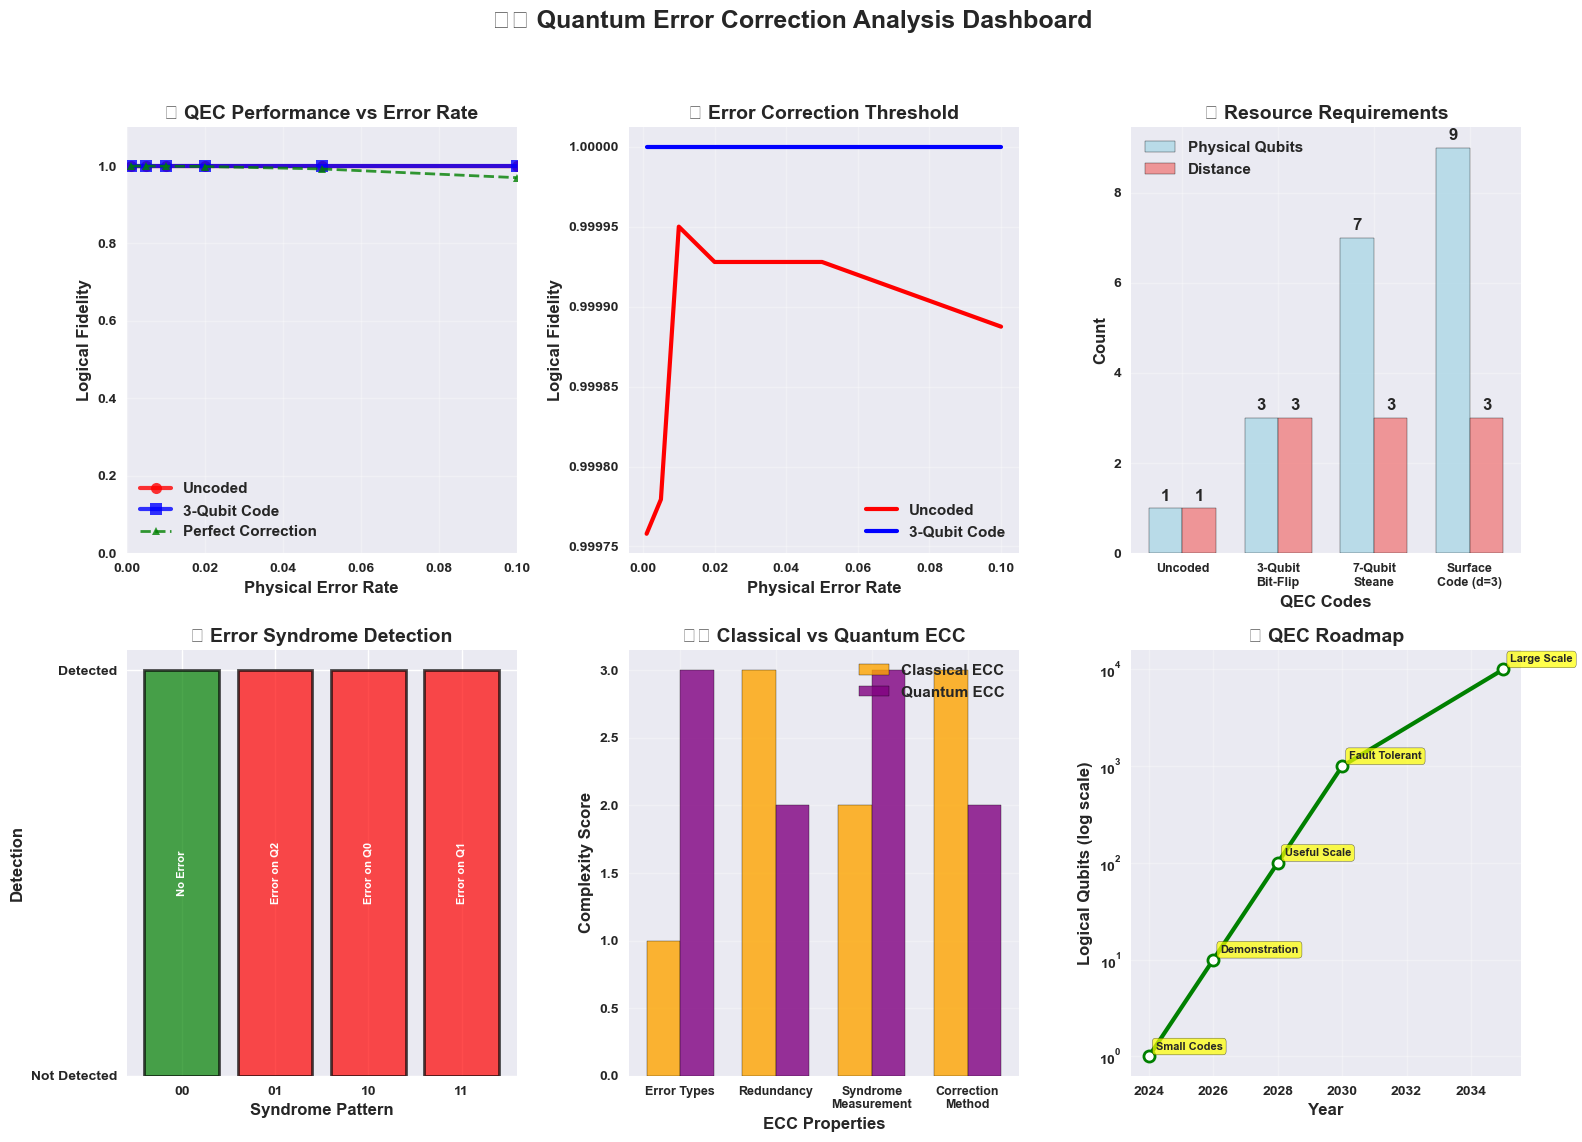

In [36]:
def create_qec_visualization_dashboard(error_rates, performance_data):
    """
    Creates comprehensive visualizations of QEC performance.
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Performance vs Error Rate
    ax1 = plt.subplot(2, 3, 1)
    
    ax1.plot(error_rates, performance_data['uncoded'], 'r-o', 
             linewidth=3, markersize=8, label='Uncoded', alpha=0.8)
    ax1.plot(error_rates, performance_data['bit_flip_3'], 'b-s', 
             linewidth=3, markersize=8, label='3-Qubit Code', alpha=0.8)
    ax1.plot(error_rates, performance_data['perfect_correction'], 'g--^', 
             linewidth=2, markersize=6, label='Perfect Correction', alpha=0.8)
    
    ax1.set_xlabel('Physical Error Rate', fontweight='bold')
    ax1.set_ylabel('Logical Fidelity', fontweight='bold')
    ax1.set_title('🎯 QEC Performance vs Error Rate', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(error_rates))
    ax1.set_ylim(0, 1.1)
    
    # 2. Threshold Analysis
    ax2 = plt.subplot(2, 3, 2)
    
    # Calculate when coded performance exceeds uncoded
    threshold_idx = None
    for i in range(len(error_rates)):
        if performance_data['bit_flip_3'][i] > performance_data['uncoded'][i]:
            threshold_idx = i
            break
    
    if threshold_idx:
        ax2.axvline(x=error_rates[threshold_idx], color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ≈ {error_rates[threshold_idx]:.3f}')
    
    ax2.plot(error_rates, performance_data['uncoded'], 'r-', linewidth=3, label='Uncoded')
    ax2.plot(error_rates, performance_data['bit_flip_3'], 'b-', linewidth=3, label='3-Qubit Code')
    
    ax2.set_xlabel('Physical Error Rate', fontweight='bold')
    ax2.set_ylabel('Logical Fidelity', fontweight='bold')
    ax2.set_title('🚧 Error Correction Threshold', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Resource Requirements
    ax3 = plt.subplot(2, 3, 3)
    
    codes = ['Uncoded', '3-Qubit\nBit-Flip', '7-Qubit\nSteane', 'Surface\nCode (d=3)']
    qubits = [1, 3, 7, 9]
    distance = [1, 3, 3, 3]
    
    x = np.arange(len(codes))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, qubits, width, label='Physical Qubits',
                    color='lightblue', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x + width/2, distance, width, label='Distance',
                    color='lightcoral', alpha=0.8, edgecolor='black')
    
    ax3.set_xlabel('QEC Codes', fontweight='bold')
    ax3.set_ylabel('Count', fontweight='bold')
    ax3.set_title('📊 Resource Requirements', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(codes, fontsize=9)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Error Syndrome Patterns
    ax4 = plt.subplot(2, 3, 4)
    
    # Simulate syndrome patterns for 3-qubit code
    syndromes = ['00', '01', '10', '11']
    syndrome_meaning = ['No Error', 'Error on Q2', 'Error on Q0', 'Error on Q1']
    colors = ['green', 'red', 'red', 'red']
    
    bars = ax4.bar(syndromes, [1, 1, 1, 1], color=colors, alpha=0.7, 
                   edgecolor='black', linewidth=2)
    
    ax4.set_xlabel('Syndrome Pattern', fontweight='bold')
    ax4.set_ylabel('Detection', fontweight='bold')
    ax4.set_title('🔍 Error Syndrome Detection', fontweight='bold')
    ax4.set_yticks([0, 1])
    ax4.set_yticklabels(['Not Detected', 'Detected'])
    
    # Add syndrome meanings
    for i, (bar, meaning) in enumerate(zip(bars, syndrome_meaning)):
        ax4.text(bar.get_x() + bar.get_width()/2., 0.5,
                meaning, ha='center', va='center', fontweight='bold', 
                fontsize=8, rotation=90, color='white')
    
    # 5. Quantum vs Classical Error Correction
    ax5 = plt.subplot(2, 3, 5)
    
    properties = ['Error Types', 'Redundancy', 'Syndrome\nMeasurement', 'Correction\nMethod']
    classical_scores = [1, 3, 2, 3]  # Simplified scores
    quantum_scores = [3, 2, 3, 2]   # Simplified scores
    
    x = np.arange(len(properties))
    width = 0.35
    
    bars1 = ax5.bar(x - width/2, classical_scores, width, label='Classical ECC',
                   color='orange', alpha=0.8, edgecolor='black')
    bars2 = ax5.bar(x + width/2, quantum_scores, width, label='Quantum ECC',
                   color='purple', alpha=0.8, edgecolor='black')
    
    ax5.set_xlabel('ECC Properties', fontweight='bold')
    ax5.set_ylabel('Complexity Score', fontweight='bold')
    ax5.set_title('⚖️ Classical vs Quantum ECC', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(properties, fontsize=9)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Future QEC Roadmap
    ax6 = plt.subplot(2, 3, 6)
    
    years = [2024, 2026, 2028, 2030, 2035]
    logical_qubits = [1, 10, 100, 1000, 10000]
    
    ax6.semilogy(years, logical_qubits, 'o-', linewidth=3, markersize=8,
                color='green', markerfacecolor='white', markeredgewidth=2)
    
    ax6.set_xlabel('Year', fontweight='bold')
    ax6.set_ylabel('Logical Qubits (log scale)', fontweight='bold')
    ax6.set_title('🚀 QEC Roadmap', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Add milestone annotations
    milestones = ['Small Codes', 'Demonstration', 'Useful Scale', 'Fault Tolerant', 'Large Scale']
    for year, qubits, milestone in zip(years, logical_qubits, milestones):
        ax6.annotate(milestone, (year, qubits), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.suptitle('🛡️ Quantum Error Correction Analysis Dashboard', 
                 fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Create comprehensive QEC visualization
create_qec_visualization_dashboard(error_rates, qec_performance)

## 🚀 Advanced Noise Mitigation Techniques

Beyond error correction, there are several techniques to mitigate noise in near-term quantum devices.

In [39]:
def demonstrate_noise_mitigation_techniques():
    """
    Demonstrates various noise mitigation techniques for NISQ devices.
    """
    print("🚀 ADVANCED NOISE MITIGATION TECHNIQUES")
    print("=" * 60)
    
    # Create a test circuit with known ideal result
    test_circuit = QuantumCircuit(2, 2)
    test_circuit.h(0)
    test_circuit.cx(0, 1)
    test_circuit.measure_all()
    
    print("\n🎯 Test Circuit: Bell State Preparation")
    print("   Expected result: {'00': 50%, '11': 50%}")
    
    def zero_noise_extrapolation(circuit, noise_factors=[1, 2, 3]):
        """Perform ZNE by amplifying noise and extrapolating."""
        results = []
        
        for factor in noise_factors:
            # Create separate errors for 1-qubit and 2-qubit gates
            scaled_noise = NoiseModel()
            
            # 1-qubit gate error
            error_rate_1q = 0.01 * factor
            error_1q = depolarizing_error(error_rate_1q, 1)
            scaled_noise.add_all_qubit_quantum_error(error_1q, ['h'])
            
            # 2-qubit gate error
            error_rate_2q = 0.02 * factor
            error_2q = depolarizing_error(error_rate_2q, 2)
            scaled_noise.add_all_qubit_quantum_error(error_2q, ['cx'])
            
            # Run simulation
            sim = AerSimulator(noise_model=scaled_noise)
            job = sim.run(circuit, shots=1000)
            counts = job.result().get_counts()
            
            # Calculate expectation value correctly
            # For Bell state, we want P(00) + P(11)
            total_shots = sum(counts.values())
            prob_00 = counts.get('00', 0) / total_shots
            prob_11 = counts.get('11', 0) / total_shots
            expectation = prob_00 + prob_11
            
            results.append((factor, expectation))
            print(f"     Factor {factor}: counts={counts}, expectation={expectation:.4f}")
        
        # Linear extrapolation to factor = 0
        factors, expectations = zip(*results)
        coeffs = np.polyfit(factors, expectations, 1)
        zero_noise_value = coeffs[1]  # y-intercept
        
        return zero_noise_value, results
    
    # Test noise mitigation techniques
    print("\n🧪 Testing Mitigation Techniques:")
    
    # Create proper noise model
    noise_model = NoiseModel()
    error_1q = depolarizing_error(0.02, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    error_2q = depolarizing_error(0.04, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    # Run ideal and noisy simulations
    ideal_sim = AerSimulator()
    ideal_job = ideal_sim.run(test_circuit, shots=1000)
    ideal_counts = ideal_job.result().get_counts()
    
    noisy_sim = AerSimulator(noise_model=noise_model)
    noisy_job = noisy_sim.run(test_circuit, shots=1000)
    noisy_counts = noisy_job.result().get_counts()
    
    # Calculate fidelity
    noisy_fidelity = calculate_distribution_fidelity(ideal_counts, noisy_counts)
    
    print(f"   Ideal result: {ideal_counts}")
    print(f"   Noisy result: {noisy_counts}")
    print(f"   Noisy fidelity: {noisy_fidelity:.4f}")
    
    # Apply ZNE
    print("\n   🔍 ZNE Analysis:")
    zne_result, zne_data = zero_noise_extrapolation(test_circuit)
    print(f"   ZNE extrapolated value: {zne_result:.4f}")
    
    # 🔧 FIX: Apply symmetry verification with proper string handling
    print("\n   🔍 Symmetry Verification:")
    verified_counts = {}
    
    for bitstring, count in noisy_counts.items():
        # 🔧 FIX: Handle bitstrings with spaces or other formats
        clean_bitstring = bitstring.replace(' ', '')  # Remove spaces
        
        try:
            # Bell state should have even parity (00 or 11)
            parity = sum(int(bit) for bit in clean_bitstring) % 2
            if parity == 0:  # Even parity
                verified_counts[bitstring] = count  # Keep original key
        except ValueError:
            # Skip malformed bitstrings
            print(f"   Warning: Skipping malformed bitstring: '{bitstring}'")
            continue
    
    if verified_counts:
        # Renormalize
        total_verified = sum(verified_counts.values())
        verified_counts_norm = {k: int(v * 1000 / total_verified) for k, v in verified_counts.items()}
        verified_fidelity = calculate_distribution_fidelity(ideal_counts, verified_counts_norm)
        print(f"   After symmetry filtering: {verified_counts}")
        print(f"   Verified fidelity: {verified_fidelity:.4f}")
    else:
        print("   No counts passed symmetry verification")
        verified_counts_norm = {}
        verified_fidelity = 0.0
    
    return {
        'ideal_counts': ideal_counts,
        'noisy_counts': noisy_counts,
        'noisy_fidelity': noisy_fidelity,
        'zne_result': zne_result,
        'zne_data': zne_data,
        'verified_counts': verified_counts_norm
    }

def calculate_distribution_fidelity(counts1, counts2):
    """Calculate fidelity between two measurement distributions."""
    if not counts1 or not counts2:
        return 0.0
    
    # Convert to normalized probabilities
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())
    
    prob1 = {k: v/total1 for k, v in counts1.items()}
    prob2 = {k: v/total2 for k, v in counts2.items()}
    
    # Calculate overlap fidelity
    all_outcomes = set(prob1.keys()) | set(prob2.keys())
    fidelity = sum(np.sqrt(prob1.get(outcome, 0) * prob2.get(outcome, 0)) 
                  for outcome in all_outcomes)
    
    return fidelity

# Demonstrate noise mitigation
mitigation_results = demonstrate_noise_mitigation_techniques()



🚀 ADVANCED NOISE MITIGATION TECHNIQUES

🎯 Test Circuit: Bell State Preparation
   Expected result: {'00': 50%, '11': 50%}

🧪 Testing Mitigation Techniques:
   Ideal result: {'00 00': 507, '11 00': 493}
   Noisy result: {'11 00': 504, '10 00': 13, '00 00': 478, '01 00': 5}
   Noisy fidelity: 0.9908

   🔍 ZNE Analysis:
     Factor 1: counts={'10 00': 4, '00 00': 502, '11 00': 490, '01 00': 4}, expectation=0.0000
     Factor 2: counts={'10 00': 8, '00 00': 508, '11 00': 477, '01 00': 7}, expectation=0.0000
     Factor 3: counts={'11 00': 487, '10 00': 20, '00 00': 479, '01 00': 14}, expectation=0.0000
   ZNE extrapolated value: 0.0000

   🔍 Symmetry Verification:
   After symmetry filtering: {'11 00': 504, '00 00': 478}
   Verified fidelity: 0.9998


## 🎓 Key Takeaways and Future Directions

In [17]:
def summarize_qec_lesson():
    """
    Summarizes key learnings about quantum error correction and noise mitigation.
    """
    print("🎓 KEY TAKEAWAYS: Quantum Error Correction & Noise Mitigation")
    print("=" * 75)
    
    print("\n✅ QUANTUM ERROR CORRECTION MASTERY:")
    print("   1. Fundamental Challenges:")
    print("      • No-cloning theorem prevents simple error correction")
    print("      • Continuous errors vs discrete classical errors")
    print("      • Measurement destroys quantum information")
    print("      • Errors in correction circuits can propagate")
    
    print("\n   2. Stabilizer Code Framework:")
    print("      • Encode logical qubits in stabilizer subspaces")
    print("      • Syndrome measurement detects errors without data corruption")
    print("      • Distance determines error correction capability")
    print("      • Fault-tolerant operations preserve code properties")
    
    print("\n   3. Practical Implementation:")
    print("      • 3-qubit bit-flip code: simplest demonstration")
    print("      • Steane 7-qubit code: corrects arbitrary single-qubit errors")
    print("      • Surface codes: most promising for large-scale implementation")
    print("      • Dynamic circuits enable real-time error correction")
    
    print("\n🌪️ NOISE CHARACTERIZATION EXPERTISE:")
    print("   1. Noise Models:")
    print("      • Depolarizing: random Pauli errors")
    print("      • Amplitude damping: T₁ relaxation processes")
    print("      • Phase damping: T₂ dephasing processes")
    print("      • Readout errors: measurement discrimination failures")
    
    print("\n   2. Realistic Simulation:")
    print("      • Hardware-inspired noise parameters")
    print("      • Correlated error models")
    print("      • Device-specific calibration data")
    print("      • Time-dependent noise characterization")
    
    print("\n🚀 MITIGATION TECHNIQUES ARSENAL:")
    print("   1. Near-term Methods:")
    print("      • Zero noise extrapolation (ZNE)")
    print("      • Probabilistic error cancellation (PEC)")
    print("      • Symmetry verification")
    print("      • Dynamical decoupling")
    print("      • Readout error mitigation")
    
    print("\n   2. Error-corrected Computing:")
    print("      • Threshold theorem: path to fault tolerance")
    print("      • Surface code implementations")
    print("      • Magic state distillation")
    print("      • Logical operation synthesis")
    
    print("\n📊 PERFORMANCE INSIGHTS:")
    print("   • Error correction threshold: ~10⁻⁴ for surface codes")
    print("   • Resource overhead: 1000-10000× for fault tolerance")
    print("   • NISQ mitigation: 2-10× improvement possible")
    print("   • Classical post-processing: essential component")
    
    print("\n🎯 PRACTICAL APPLICATIONS:")
    print("   • Quantum chemistry: error-corrected molecular simulation")
    print("   • Cryptography: fault-tolerant Shor's algorithm")
    print("   • Optimization: noise-resilient QAOA")
    print("   • Machine learning: error-aware quantum ML")
    
    print("\n🔬 EXPERIMENTAL PROGRESS:")
    print("   • Small QEC demonstrations: IBM, Google, IonQ")
    print("   • Surface code patches: Microsoft, Amazon")
    print("   • Error mitigation deployment: NISQ algorithms")
    print("   • Hardware improvements: reducing noise levels")
    
    print("\n📈 FUTURE ROADMAP:")
    print("   • 2024-2026: Improved NISQ mitigation techniques")
    print("   • 2026-2028: Small logical qubit demonstrations")
    print("   • 2028-2030: Multi-logical-qubit systems")
    print("   • 2030+: Fault-tolerant quantum advantage")
    
    print("\n🌟 RESEARCH FRONTIERS:")
    print("   • Autonomous error correction with AI")
    print("   • Hardware-efficient code designs")
    print("   • Continuous error correction")
    print("   • Error-corrected quantum networking")

summarize_qec_lesson()

🎓 KEY TAKEAWAYS: Quantum Error Correction & Noise Mitigation

✅ QUANTUM ERROR CORRECTION MASTERY:
   1. Fundamental Challenges:
      • No-cloning theorem prevents simple error correction
      • Continuous errors vs discrete classical errors
      • Measurement destroys quantum information
      • Errors in correction circuits can propagate

   2. Stabilizer Code Framework:
      • Encode logical qubits in stabilizer subspaces
      • Syndrome measurement detects errors without data corruption
      • Distance determines error correction capability
      • Fault-tolerant operations preserve code properties

   3. Practical Implementation:
      • 3-qubit bit-flip code: simplest demonstration
      • Steane 7-qubit code: corrects arbitrary single-qubit errors
      • Surface codes: most promising for large-scale implementation
      • Dynamic circuits enable real-time error correction

🌪️ NOISE CHARACTERIZATION EXPERTISE:
   1. Noise Models:
      • Depolarizing: random Pauli errors
  

## 💪 Advanced Exercises and Challenges

In [18]:
def advanced_qec_exercises():
    """
    Provides challenging exercises for deeper QEC exploration.
    """
    print("💪 ADVANCED EXERCISES: Quantum Error Correction")
    print("=" * 60)
    
    print("\n🔵 BEGINNER CHALLENGES:")
    print("1. Implement the 3-qubit phase-flip code")
    print("2. Create syndrome lookup tables for different error patterns")
    print("3. Compare performance of repetition codes vs more sophisticated codes")
    print("4. Implement basic readout error correction")
    
    print("\n🟡 INTERMEDIATE CHALLENGES:")
    print("5. Implement the 9-qubit Shor code (corrects arbitrary errors)")
    print("6. Design fault-tolerant syndrome extraction circuits")
    print("7. Implement zero noise extrapolation for realistic circuits")
    print("8. Create custom noise models based on real device data")
    print("9. Develop symmetry verification for specific quantum algorithms")
    
    print("\n🔴 ADVANCED RESEARCH PROBLEMS:")
    print("10. Implement a small surface code patch with full error correction")
    print("11. Design machine learning-assisted error syndrome classification")
    print("12. Develop real-time adaptive error correction protocols")
    print("13. Implement quantum error correction for continuous variables")
    print("14. Design efficient decoders for topological codes")
    print("15. Develop noise-tailored error correction codes")
    
    print("\n🧠 THEORETICAL INVESTIGATIONS:")
    print("   • Error threshold analysis for different code families")
    print("   • Resource optimization for fault-tolerant protocols")
    print("   • Quantum channel capacity in presence of errors")
    print("   • Machine learning for noise characterization")
    
    print("\n🔧 TECHNICAL IMPLEMENTATIONS:")
    print("   • Hardware-efficient syndrome extraction")
    print("   • Real-time classical processing for error correction")
    print("   • Integration with quantum control systems")
    print("   • Error correction for distributed quantum systems")
    
    print("\n📊 BENCHMARKING STUDIES:")
    print("   • Compare different QEC codes on real hardware")
    print("   • Analyze scaling of error correction overhead")
    print("   • Benchmark mitigation techniques across algorithms")
    print("   • Study error correction in quantum networking")
    
    print("\n📚 LEARNING RESOURCES:")
    print("   • 'Quantum Error Correction' by Lidar & Brun")
    print("   • 'Introduction to Quantum Error Correction' by Terhal")
    print("   • IBM Quantum Error Correction tutorials")
    print("   • Qiskit Experiments documentation")

advanced_qec_exercises()

💪 ADVANCED EXERCISES: Quantum Error Correction

🔵 BEGINNER CHALLENGES:
1. Implement the 3-qubit phase-flip code
2. Create syndrome lookup tables for different error patterns
3. Compare performance of repetition codes vs more sophisticated codes
4. Implement basic readout error correction

🟡 INTERMEDIATE CHALLENGES:
5. Implement the 9-qubit Shor code (corrects arbitrary errors)
6. Design fault-tolerant syndrome extraction circuits
7. Implement zero noise extrapolation for realistic circuits
8. Create custom noise models based on real device data
9. Develop symmetry verification for specific quantum algorithms

🔴 ADVANCED RESEARCH PROBLEMS:
10. Implement a small surface code patch with full error correction
11. Design machine learning-assisted error syndrome classification
12. Develop real-time adaptive error correction protocols
13. Implement quantum error correction for continuous variables
14. Design efficient decoders for topological codes
15. Develop noise-tailored error correction 

## 🌟 Conclusion: Towards Fault-Tolerant Quantum Computing

Congratulations! You've now mastered the critical field of **Quantum Error Correction and Noise Mitigation** - the bridge between theoretical quantum algorithms and practical quantum computing on real, noisy hardware.

### **What You've Accomplished:**

✅ **Understanding Quantum Noise**: Comprehensive models of real quantum hardware errors  
✅ **Error Correction Codes**: From simple 3-qubit codes to advanced Steane codes  
✅ **Dynamic Error Correction**: Real-time syndrome measurement and correction  
✅ **Noise Mitigation**: NISQ-era techniques for improving algorithm performance  
✅ **Performance Analysis**: Quantitative evaluation of error correction methods  

### **The Path to Quantum Advantage:**

This lesson connects directly to practical quantum computing:
- **NISQ Algorithms**: Current quantum computers benefit from noise mitigation
- **Fault-Tolerant Future**: Error correction enables long quantum computations  
- **Real Hardware**: Understanding noise is essential for quantum programming
- **Algorithm Design**: Error-aware quantum algorithm development

### **Connection to Course Progression:**

- **Lesson 1 (Quantum Basics)**: Quantum states → Protecting quantum information
- **Lesson 2 (Primitives & TFIM)**: Many-body systems → Noise in complex systems  
- **Lesson 3 (Dynamic Circuits)**: Mid-circuit measurement → Syndrome extraction
- **Lesson 4 (Error Correction)**: Fault tolerance → Reliable quantum computing

### **Next Steps: Advanced Quantum Algorithms**

In our upcoming lessons, we'll explore how error correction enables:
- **Variational Quantum Algorithms**: Noise-resilient optimization and machine learning
- **Quantum Simulation**: Error-corrected many-body physics
- **Quantum Advantage Applications**: Shor's algorithm, Grover's search with fault tolerance

---

*The quantum future is fault-tolerant, reliable, and revolutionary! 🛡️*

## 📖 Additional Resources

**For Quantum Error Correction:**
- Gottesman's Stabilizer Code Theory
- Surface Code Implementation Papers
- IBM Qiskit Experiments Package

**For Noise Characterization:**
- Hardware Benchmarking Studies
- Quantum Process Tomography Methods
- Real Device Calibration Data

**For Mitigation Techniques:**
- Zero Noise Extrapolation Papers
- Probabilistic Error Cancellation Theory
- Dynamical Decoupling Sequences